In [1]:
%matplotlib inline
import numpy as np
import skvideo.io
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import cv2
import scipy.io

In [4]:
#read video
videodata = skvideo.io.vread("1.mp4") 
print(videodata.shape)

(205, 368, 640, 3)


In [ ]:
#Pick reference points on the image and output these points for matlab to do point tracking
im1 = videodata[0]
print(im1.shape)
plt.figure()
plt.imshow(im1)
x = plt.ginput(0, 0) 
print(x) 

(368, 640, 3)


In [ ]:
#input tracking points for each frame from matlab file
mat = scipy.io.loadmat('point.mat')
mat['point_array'].shape

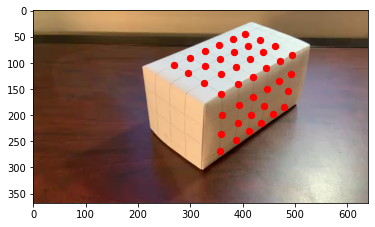

In [5]:
#show these points on the image to check
idx=0
im1 = videodata[idx]
plt.imshow(im1)
plt.scatter(x=mat['point_array'][:,0,idx], y=mat['point_array'][:,1,idx], c='r', s=40)
plt.show()

In [7]:
#get the gray image
gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
gray.shape[::-1]

(640, 368)

In [8]:
#define 3D global coordinate
objp = np.array([[0,1,0],[0,2,0],[0,3,0],[0,4,0],[0,5,0],[0,6,0],\
                [0,1,1],[0,2,1],[0,3,1],[0,4,1],[0,6,1],\
                [0,1,2],[0,2,2],[0,3,2],[0,4,2],[0,5,2],[0,6,2],\
                [0,1,3],[0,2,3],[0,3,3],[0,4,3],[0,5,3],[0,6,3],\
                [1,1,3],[1,2,3],[1,3,3],[1,4,3],[1,5,3],[1,6,3],\
                [2,1,3],[2,2,3],[2,3,3],[2,4,3],[2,5,3],[2,6,3],\
                [3,1,3],[3,2,3],[3,3,3],[3,4,3],[3,5,3],[3,6,3]],np.float32)
objp

array([[0., 1., 0.],
       [0., 2., 0.],
       [0., 3., 0.],
       [0., 4., 0.],
       [0., 5., 0.],
       [0., 6., 0.],
       [0., 1., 1.],
       [0., 2., 1.],
       [0., 3., 1.],
       [0., 4., 1.],
       [0., 6., 1.],
       [0., 1., 2.],
       [0., 2., 2.],
       [0., 3., 2.],
       [0., 4., 2.],
       [0., 5., 2.],
       [0., 6., 2.],
       [0., 1., 3.],
       [0., 2., 3.],
       [0., 3., 3.],
       [0., 4., 3.],
       [0., 5., 3.],
       [0., 6., 3.],
       [1., 1., 3.],
       [1., 2., 3.],
       [1., 3., 3.],
       [1., 4., 3.],
       [1., 5., 3.],
       [1., 6., 3.],
       [2., 1., 3.],
       [2., 2., 3.],
       [2., 3., 3.],
       [2., 4., 3.],
       [2., 5., 3.],
       [2., 6., 3.],
       [3., 1., 3.],
       [3., 2., 3.],
       [3., 3., 3.],
       [3., 4., 3.],
       [3., 5., 3.],
       [3., 6., 3.]], dtype=float32)

In [14]:
#Get the 2D image coordinate
idx=0
imgp=np.array(mat['point_array'][:,:,idx],np.float32)

In [15]:
#Define the parameters of camera
camera_matrix = np.zeros((3, 3),'float32')
camera_matrix[0,0]= 2200.0
camera_matrix[1,1]= 2200.0
camera_matrix[2,2]=1.0
camera_matrix[0,2]=368/2
camera_matrix[1,2]=640/2

dist_coefs = np.zeros(4,'float32')

In [16]:
#Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([objp], [imgp], gray.shape[::-1], \
                                                   camera_matrix,dist_coefs,flags=cv2.CALIB_USE_INTRINSIC_GUESS)

In [17]:
#Get projection matrix
rotation_mat = np.zeros(shape=(3, 3))
R = cv2.Rodrigues(rvecs[0], rotation_mat)[0]
P = np.matmul(mtx,np.column_stack((R,tvecs[0])))

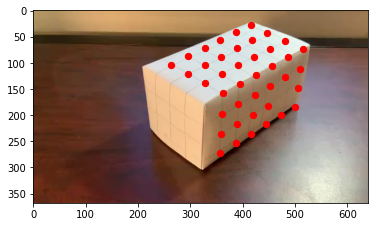

In [18]:
#reprojection
#rotation_mat = np.zeros(shape=(3, 3))
#R = cv2.Rodrigues(rvecs[idx], rotation_mat)[0]
#P = np.matmul(mtx,np.column_stack((R,tvecs[idx])))
im1 = videodata[idx]
plt.imshow(im1)
m=np.matmul(P,np.column_stack((objp,np.ones((41,1)))).T)
plt.scatter(x=m[0,:]/m[2,:], y=m[1,:]/m[2,:], c='r', s=40)
plt.show()

In [15]:
#function for cube drawing
def draw(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)
    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(0,0,255),3)
    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(255),3)
    return img

In [16]:
#Define 3D coordinate of cube's vertices
objp = np.array([[1,1,3],[1,2,3],[2,2,3],[2,1,3],\
                [1,1,4],[1,2,4],[2,2,4],[2,1,4]],np.float32)
m=np.matmul(P,np.column_stack((objp,np.ones((8,1)))).T)
x=m[0,:]/m[2,:]
y=m[1,:]/m[2,:]
imgpts=np.column_stack((np.array([x]).T,np.array([y]).T))

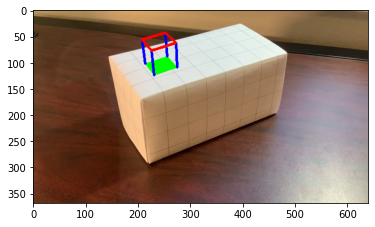

In [17]:
#Check the result
new_img=draw(im1, imgpts)
plt.imshow(new_img)
#plt.show()

In [24]:
#Go through the above process for all the frames
import skvideo.io
import numpy as np

objp = np.array([[0,1,0],[0,2,0],[0,3,0],[0,4,0],[0,5,0],[0,6,0],\
                [0,1,1],[0,2,1],[0,3,1],[0,4,1],[0,6,1],\
                [0,1,2],[0,2,2],[0,3,2],[0,4,2],[0,5,2],[0,6,2],\
                [0,1,3],[0,2,3],[0,3,3],[0,4,3],[0,5,3],[0,6,3],\
                [1,1,3],[1,2,3],[1,3,3],[1,4,3],[1,5,3],[1,6,3],\
                [2,1,3],[2,2,3],[2,3,3],[2,4,3],[2,5,3],[2,6,3],\
                [3,1,3],[3,2,3],[3,3,3],[3,4,3],[3,5,3],[3,6,3]],np.float32)

camera_matrix = np.zeros((3, 3),'float32')
camera_matrix[0,0]= 2200.0
camera_matrix[1,1]= 2200.0
camera_matrix[2,2]=1.0
camera_matrix[0,2]=368/2
camera_matrix[1,2]=640/2

dist_coefs = np.zeros(4,'float32')

writer = skvideo.io.FFmpegWriter("output.avi")
for i in range(205):
    imgp=np.array(mat['point_array'][:,:,i],np.float32)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([objp], [imgp], gray.shape[::-1], \
                                                   camera_matrix,dist_coefs,flags=cv2.CALIB_USE_INTRINSIC_GUESS)
    rotation_mat = np.zeros(shape=(3, 3))
    R = cv2.Rodrigues(rvecs[0], rotation_mat)[0]
    P = np.matmul(mtx,np.column_stack((R,tvecs[0])))
    objp2 = np.array([[1,1,3],[1,2,3],[2,2,3],[2,1,3],\
                [1,1,4],[1,2,4],[2,2,4],[2,1,4]],np.float32)
    m=np.matmul(P,np.column_stack((objp2,np.ones((8,1)))).T)
    x=m[0,:]/m[2,:]
    y=m[1,:]/m[2,:]
    imgpts=np.column_stack((np.array([x]).T,np.array([y]).T))
    im1 = videodata[i]
    new_img=draw(im1, imgpts)
    writer.writeFrame(new_img.astype(np.uint8))
writer.close()

In [6]:
import cv2
video = cv2.VideoCapture("mov1.MOV")

In [6]:
#Opencv point tracking 
import cv2
import sys

# Set up tracker.

    # Instead of MIL, you can also use
tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']
tracker_type = tracker_types[4]
if tracker_type == 'MEDIANFLOW':
    tracker = cv2.TrackerMedianFlow_create()

# Read video

video = cv2.VideoCapture("mov1.MOV")

# Read first frame.

ok, frame = video.read()
if not ok:
    print('Cannot read video file')
    sys.exit()

bbox = (968.6244239631333 - 4, 843.1082949308754 - 4, 8, 8)

# Uncomment the line below to select a different bounding box
# bbox = cv2.selectROI(frame, False)

# Initialize tracker with first frame and bounding box
ok = tracker.init(frame, bbox)

while True:

    # Read a new frame
    ok, frame = video.read()
    if not ok:
        break

    timer = cv2.getTickCount()
    
    # Update tracker
    ok, bbox = tracker.update(frame)
    
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);
    
    # Draw bounding box
    if ok:
        # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
        
    else :
    # Tracking failure
        cv2.putText(frame, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)

    # Display tracker type on frame
    cv2.putText(frame, tracker_type + " Tracker", (100,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);

    # Display FPS on frame
    cv2.putText(frame, "FPS : " + str(int(fps)), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);
    # Display result
    cv2.imshow("Tracking", frame)
    # Exit if ESC pressed
    k = cv2.waitKey(1) & 0xff

    if k == 27 : break